# Roosvelt National Forest

Let's load the libraries and import the relevant data.

In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
from itertools import product
from sklearn.mixture import GaussianMixture


import sys

from sklearn import preprocessing

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier

from mlxtend.classifier import StackingCVClassifier
    


In [2]:
data    = pd.read_csv('./data/covtype.csv')

# EDA

In [4]:
data.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [5]:
print('Data shape: '+ str(train.shape))


Data shape: (15120, 56)


The Soil_Type variables look like one-hot encoded.

In [6]:
soil_cols = [col  for col in data.columns.values if col.startswith('Soil_Type')]


In [7]:
#Checking if there is a sample with not exactly one soil class
np.sum(np.sum(data[soil_cols].values, axis=1)!=1)

0

We are going to convert the Soil_CLass info from one-hot to label.

In [8]:
data_soil=data.copy()[soil_cols]
data_soil['Soil_Class']=np.argmax(data_soil.values, axis=1)
data['Soil_Class']=data_soil['Soil_Class']
data.drop(soil_cols, axis=1, inplace=True)
data.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Cover_Type,Soil_Class
0,2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,5,28
1,2590,56,2,212,-6,390,220,235,151,6225,1,0,0,0,5,28
2,2804,139,9,268,65,3180,234,238,135,6121,1,0,0,0,2,11
3,2785,155,18,242,118,3090,238,238,122,6211,1,0,0,0,2,29
4,2595,45,2,153,-1,391,220,234,150,6172,1,0,0,0,5,28


The Wilderness_Area variables also look like one-hot encoded.

In [9]:
wild_cols = [col  for col in data.columns.values if col.startswith('Wilderness_Area')]
np.sum(np.sum(data[wild_cols].values,axis=1)!=1)

0

In [10]:
data_wild=data.copy()[wild_cols]
data_wild['Wilderness_Area']=np.argmax(data_wild.values, axis=1)
data['Wilderness_Area']=data_wild['Wilderness_Area']
data.drop(wild_cols, axis=1, inplace=True)
data.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Cover_Type,Soil_Class,Wilderness_Area
0,2596,51,3,258,0,510,221,232,148,6279,5,28,0
1,2590,56,2,212,-6,390,220,235,151,6225,5,28,0
2,2804,139,9,268,65,3180,234,238,135,6121,2,11,0
3,2785,155,18,242,118,3090,238,238,122,6211,2,29,0
4,2595,45,2,153,-1,391,220,234,150,6172,5,28,0


Now we describe data set.

In [11]:
data.describe(include='all')

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Cover_Type,Soil_Class,Wilderness_Area
count,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000
mean,2959.365301,155.656807,14.103704,269.428217,46.418855,2350.146611,212.146049,223.318716,142.528263,1980.291226,2.051471,23.362443,1.114462
std,279.984734,111.913721,7.488242,212.549356,58.295232,1559.254870,26.769889,19.768697,38.274529,1324.195210,1.396504,9.485405,1.061295
min,1859.000000,0.000000,0.000000,0.000000,-173.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,2809.000000,58.000000,9.000000,108.000000,7.000000,1106.000000,198.000000,213.000000,119.000000,1024.000000,1.000000,19.000000,0.000000
50%,2996.000000,127.000000,13.000000,218.000000,30.000000,1997.000000,218.000000,226.000000,143.000000,1710.000000,2.000000,28.000000,1.000000
75%,3163.000000,260.000000,18.000000,384.000000,69.000000,3328.000000,231.000000,237.000000,168.000000,2550.000000,2.000000,30.000000,2.000000
max,3858.000000,360.000000,66.000000,1397.000000,601.000000,7117.000000,254.000000,254.000000,254.000000,7173.000000,7.000000,39.000000,3.000000


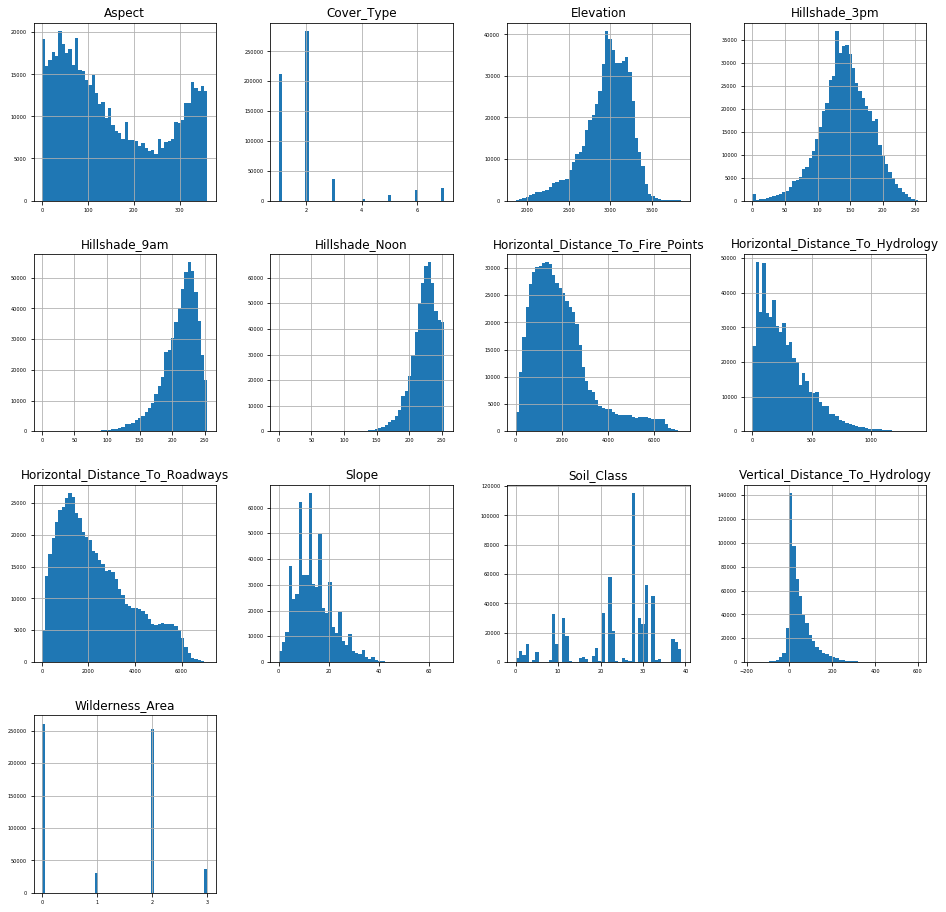

In [12]:
data.hist(figsize=(16, 16), bins=50, xlabelsize=5, ylabelsize=5);

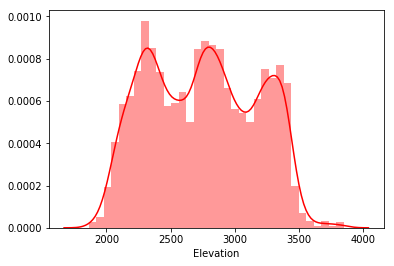

In [13]:
#f, axes = plt.subplots(1, 1, figsize=(7, 7), sharex=True, sharey=True)

sns.distplot(train['Elevation'], color="r")
#sns.distplot(test['Elevation'], color="b", ax=axes[1])


Now we do more plots on the Data set to find some correlations.

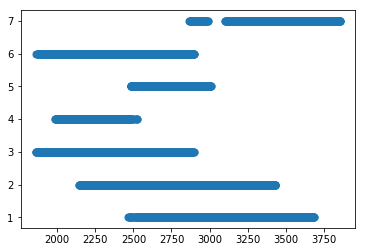

In [14]:
plt.scatter(data.Elevation, data.Cover_Type,  s=50)


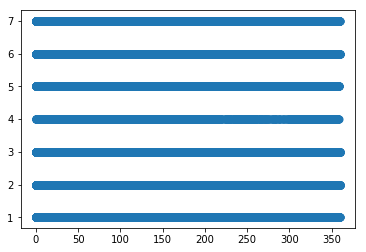

In [15]:
plt.scatter(data.Aspect, data.Cover_Type, s=50)


Text(0, 0.5, '3pm')

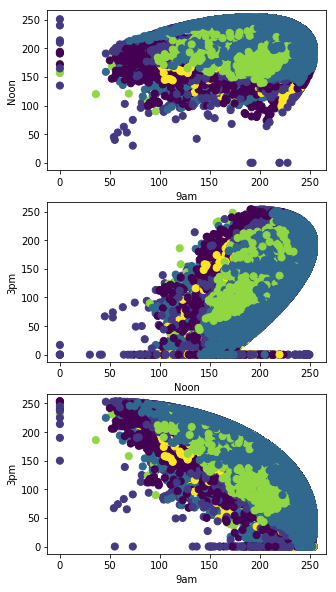

In [16]:
plt.figure(figsize=(5,10))
plt.subplot(311)
plt.scatter(data.Hillshade_9am, data.Hillshade_Noon, s=50, c=data.Cover_Type)
plt.xlabel("9am")
plt.ylabel("Noon")

plt.subplot(312)
plt.scatter(data.Hillshade_Noon, data.Hillshade_3pm, s=50, c=data.Cover_Type)
plt.xlabel("Noon")
plt.ylabel("3pm")

plt.subplot(313)
plt.scatter(data.Hillshade_9am, data.Hillshade_3pm, s=50, c=data.Cover_Type)
plt.xlabel("9am")
plt.ylabel("3pm")


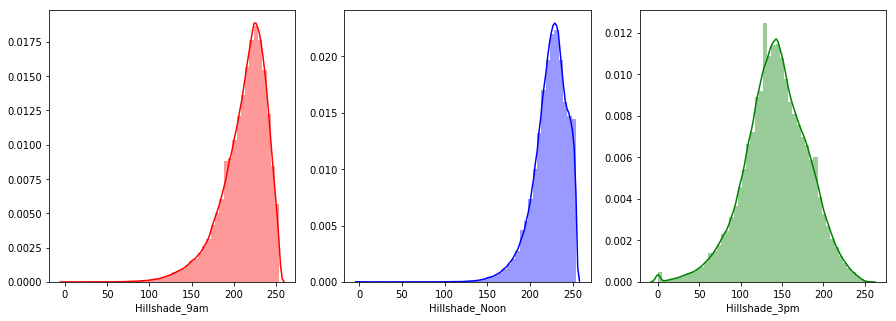

In [17]:
plt.figure(figsize=(15,5))
plt.subplot(131)
sns.distplot(data['Hillshade_9am'], color="r")
plt.subplot(132)

sns.distplot(data['Hillshade_Noon'], color="b")
plt.subplot(133)

sns.distplot(data['Hillshade_3pm'], color="g")

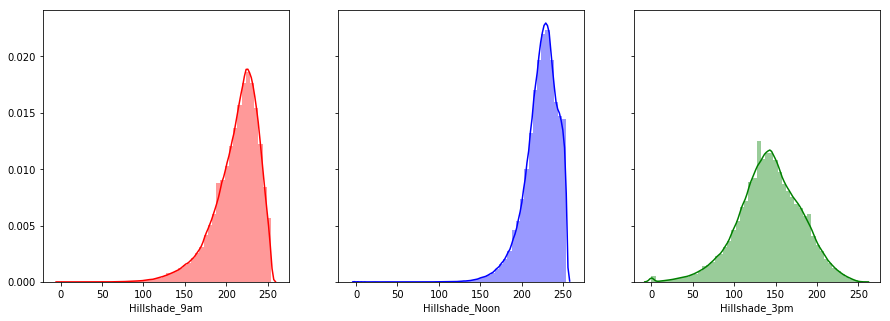

In [18]:
f, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

sns.distplot(data['Hillshade_9am'], color="r", ax=axes[0])
sns.distplot(data['Hillshade_Noon'], color="b", ax=axes[1])
sns.distplot(data['Hillshade_3pm'], color="g", ax=axes[2])

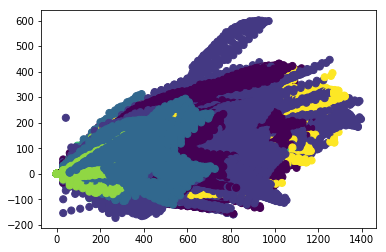

In [19]:
plt.scatter(data.Horizontal_Distance_To_Hydrology, 
            data.Vertical_Distance_To_Hydrology, s=50, c=data.Cover_Type)


Text(0, 0.5, 'Elevation')

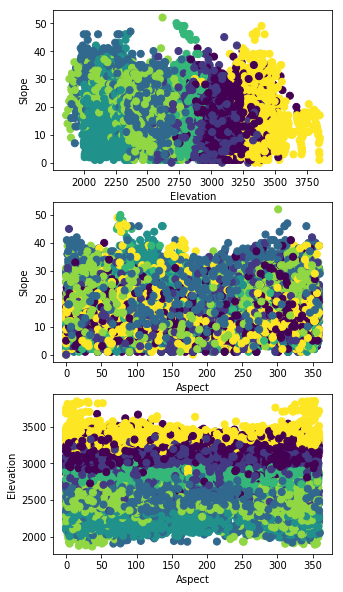

In [20]:
plt.figure(figsize=(5,10))
plt.subplot(311)
plt.scatter(train.Elevation, train.Slope, s=50, c=train.Cover_Type)
plt.xlabel("Elevation")
plt.ylabel("Slope")
 
plt.subplot(312)
plt.scatter(train.Aspect, train.Slope, s=50, c=train.Cover_Type)
plt.xlabel("Aspect")
plt.ylabel("Slope")

plt.subplot(313)
plt.scatter(train.Aspect, train.Elevation, s=50, c=train.Cover_Type)
plt.xlabel("Aspect")
plt.ylabel("Elevation")


Text(0, 0.5, 'Soil Class')

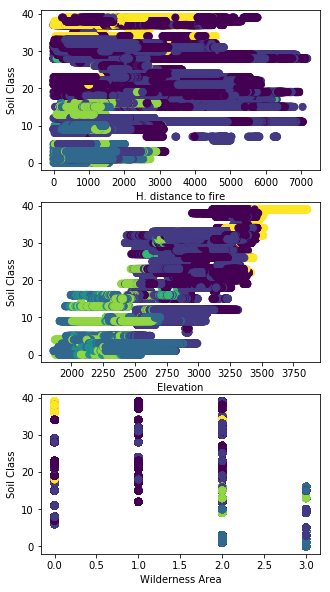

In [21]:
plt.figure(figsize=(5,10))
plt.subplot(311)
plt.scatter(data.Horizontal_Distance_To_Fire_Points, data.Soil_Class, s=50, c=data.Cover_Type)
plt.xlabel("H. distance to fire")
plt.ylabel("Soil Class")
 
plt.subplot(312)
plt.scatter(data.Elevation, data.Soil_Class, s=50, c=data.Cover_Type)
plt.xlabel("Elevation")
plt.ylabel("Soil Class")

plt.subplot(313)
plt.scatter(data.Wilderness_Area, data.Soil_Class, s=50, c=data.Cover_Type)
plt.xlabel("Wilderness Area")
plt.ylabel("Soil Class")



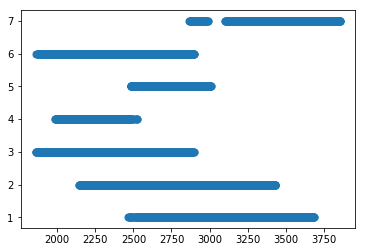

In [22]:
plt.scatter( data.Elevation,data.Cover_Type, s=50)


Text(0, 0.5, 'Cover Type')

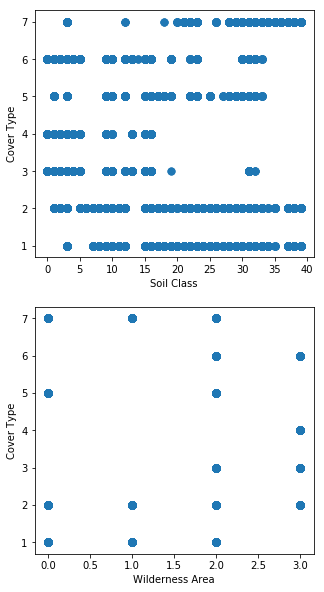

In [23]:
plt.figure(figsize=(5,10))
plt.subplot(211)
plt.scatter( data.Soil_Class,data.Cover_Type, s=50)
plt.xlabel("Soil Class")
plt.ylabel("Cover Type")
 
plt.subplot(212)
plt.scatter(data.Wilderness_Area, data.Cover_Type, s=50)
plt.xlabel("Wilderness Area")
plt.ylabel("Cover Type")





Now we'll look for outliers using boxplots. We will create a new dataframe from the data set, but with the columns normalized, so we can inspect easily the distributions.

In [24]:
from sklearn import preprocessing


In [25]:
x = data.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
data_scaled = min_max_scaler.fit_transform(x)
df_data_scaled = pd.DataFrame(data_scaled, columns=data.columns)

C:\Users\atsub\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


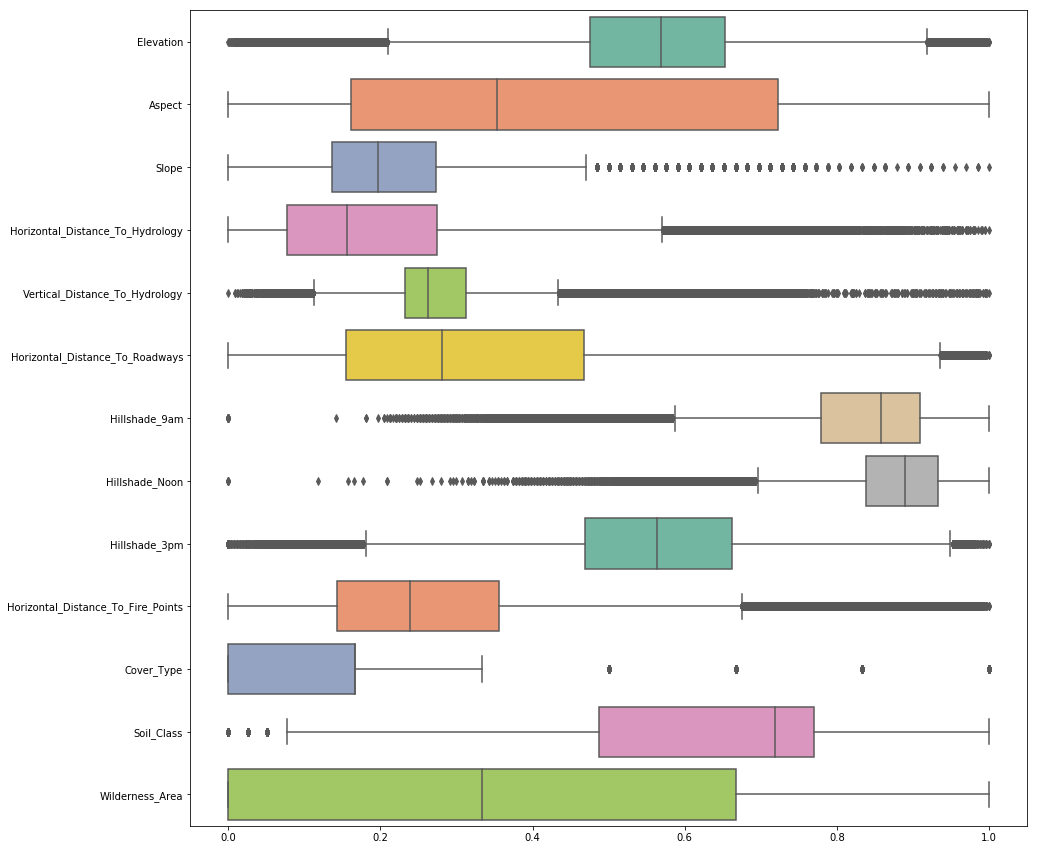

In [26]:
plt.figure(figsize=(15, 15))
sns.boxplot(data=df_data_scaled, orient="h", palette="Set2")
plt.show()

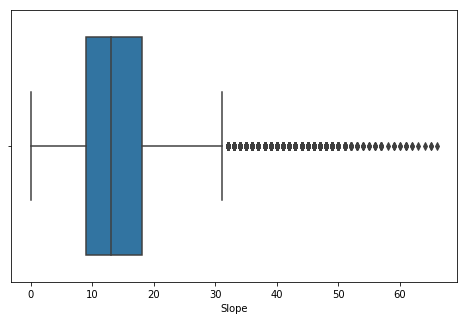

In [27]:
plt.figure(figsize=(8, 5))
sns.boxplot(data.Slope)
plt.show()

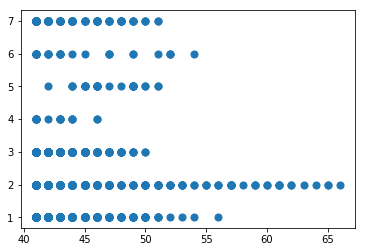

In [28]:
plt.scatter(data[data.Slope>40].Slope, data[data.Slope>40].Cover_Type, s=50)


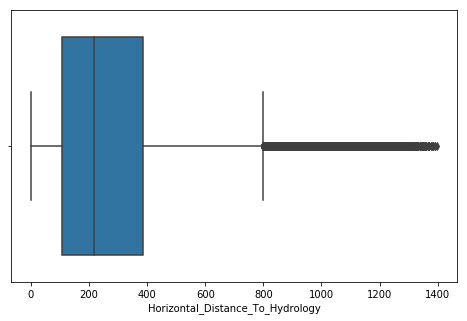

In [29]:
plt.figure(figsize=(8, 5))
sns.boxplot(data.Horizontal_Distance_To_Hydrology)
plt.show()

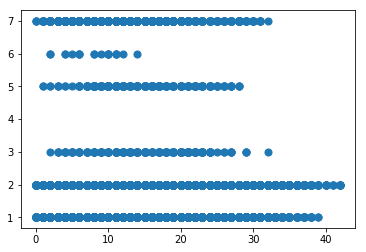

In [30]:
plt.scatter(data[data.Horizontal_Distance_To_Hydrology>600].Slope, data[data.Horizontal_Distance_To_Hydrology>600].Cover_Type, s=50)


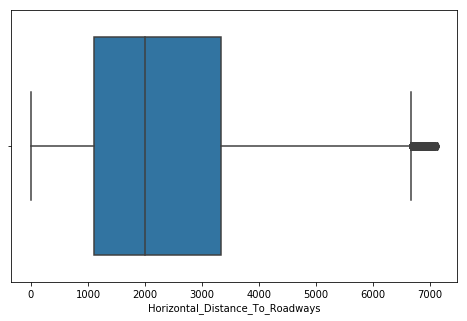

In [31]:
plt.figure(figsize=(8, 5))
sns.boxplot(data.Horizontal_Distance_To_Roadways)
plt.show()

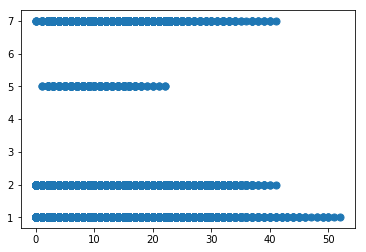

In [32]:
plt.scatter(data[data.Horizontal_Distance_To_Roadways>4000].Slope, data[data.Horizontal_Distance_To_Roadways>4000].Cover_Type, s=50)


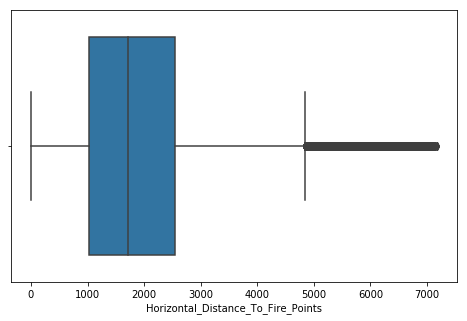

In [33]:
plt.figure(figsize=(8, 5))
sns.boxplot(data.Horizontal_Distance_To_Fire_Points)
plt.show()

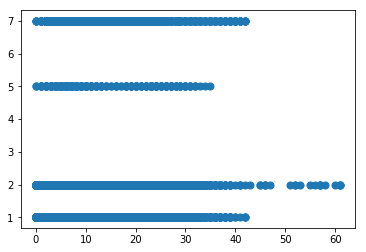

In [34]:
plt.scatter(data[data.Horizontal_Distance_To_Fire_Points>3000].Slope, data[data.Horizontal_Distance_To_Fire_Points>3000].Cover_Type, s=50)


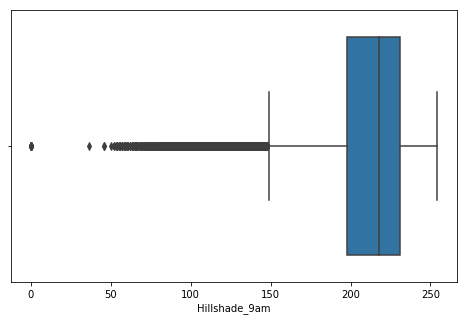

In [35]:
plt.figure(figsize=(8, 5))
sns.boxplot(data.Hillshade_9am)
plt.show()

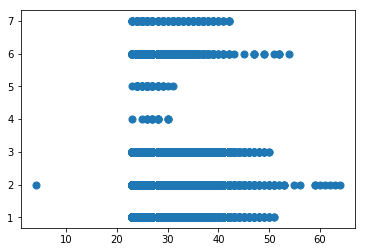

In [36]:
plt.scatter(data[data.Hillshade_9am<150].Slope, data[data.Hillshade_9am<150].Cover_Type, s=50)


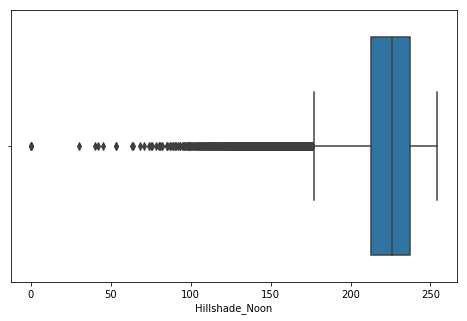

In [37]:
plt.figure(figsize=(8, 5))
sns.boxplot(data.Hillshade_Noon)
plt.show()

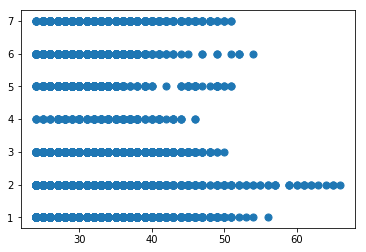

In [38]:
plt.scatter(data[data.Hillshade_Noon<180].Slope, data[data.Hillshade_Noon<180].Cover_Type, s=50)


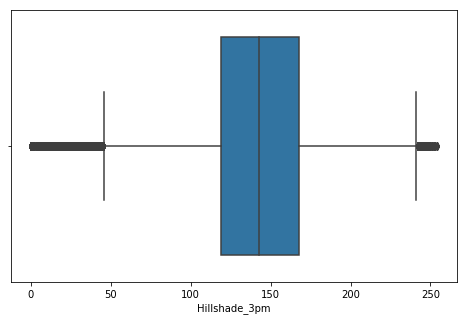

In [39]:
plt.figure(figsize=(8, 5))
sns.boxplot(data.Hillshade_3pm)
plt.show()

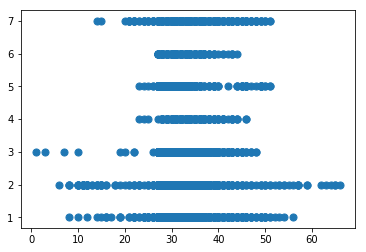

In [40]:
plt.scatter(data[data.Hillshade_3pm<50].Slope, data[data.Hillshade_3pm<50].Cover_Type, s=50)


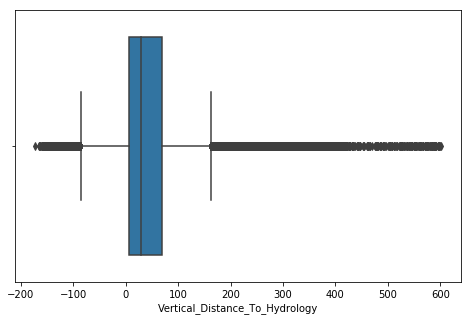

In [41]:
plt.figure(figsize=(8, 5))
sns.boxplot(data.Vertical_Distance_To_Hydrology)
plt.show()

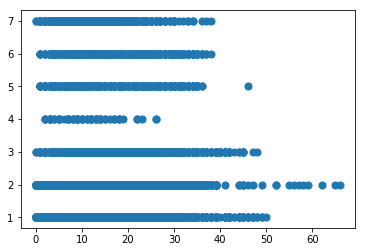

In [42]:
plt.scatter(data[data.Vertical_Distance_To_Hydrology<0].Slope, data[data.Vertical_Distance_To_Hydrology<0].Cover_Type, s=50)


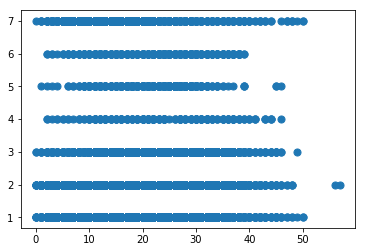

In [43]:
plt.scatter(data[data.Vertical_Distance_To_Hydrology>150].Slope, data[data.Vertical_Distance_To_Hydrology>150].Cover_Type, s=50)


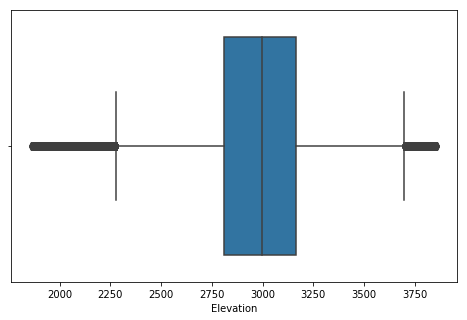

In [44]:
plt.figure(figsize=(8, 5))
sns.boxplot(data.Elevation)
plt.show()

# Feature Engineering

In [45]:
X=data.drop(['Cover_Type'] , axis =1)
X.shape

(581012, 12)

In [46]:
Y=data['Cover_Type']
Y.head()

0    5
1    5
2    2
3    2
4    5
Name: Cover_Type, dtype: int64

We plot some numeric relations betwee features and add them to the features in case we find them useful.

In [47]:
X['Distance_To_Hydrology']=np.linalg.norm([X.Horizontal_Distance_To_Hydrology,
                                           X.Vertical_Distance_To_Hydrology], axis=0)

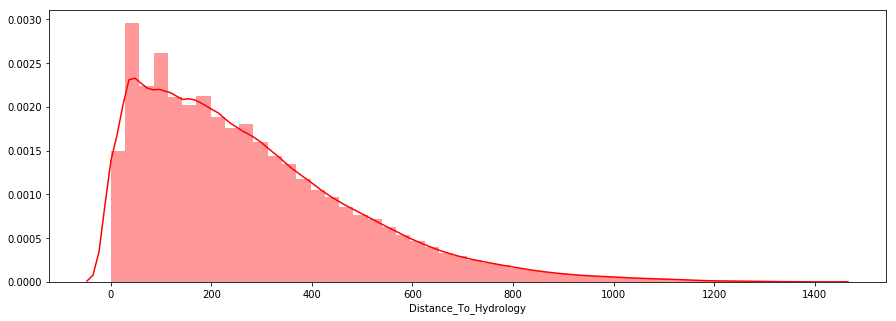

In [48]:
plt.figure(figsize=(15,5))

sns.distplot(X.Distance_To_Hydrology , color="r")

Text(0, 0.5, 'Cover Type')

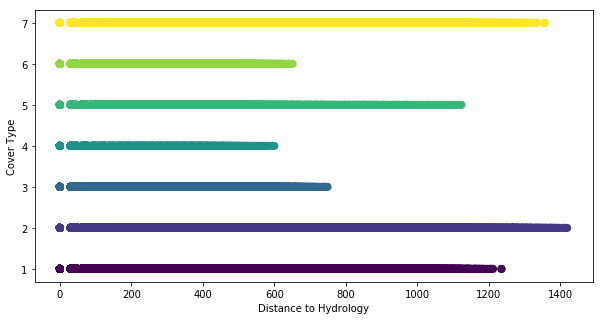

In [49]:
plt.figure(figsize=(10,5))
plt.scatter(X.Distance_To_Hydrology, Y, s=50, c=data.Cover_Type)
plt.xlabel("Distance to Hydrology")
plt.ylabel("Cover Type")

In [50]:
X['M_Distance']=np.linalg.norm([X.Horizontal_Distance_To_Hydrology,
                                X.Horizontal_Distance_To_Fire_Points,
                               X.Horizontal_Distance_To_Roadways], axis=0)

Text(0, 0.5, 'Cover Type')

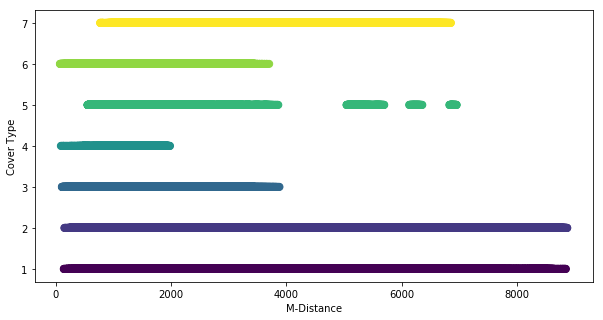

In [51]:
plt.figure(figsize=(10,5))
plt.scatter(X.M_Distance, Y, s=50, c=data.Cover_Type)
plt.xlabel("M-Distance")
plt.ylabel("Cover Type")

In [52]:
X['N_Distance']=(
    X.Horizontal_Distance_To_Fire_Points+X.Horizontal_Distance_To_Roadways)/(X.Horizontal_Distance_To_Hydrology+0.01)

Text(0, 0.5, 'Cover Type')

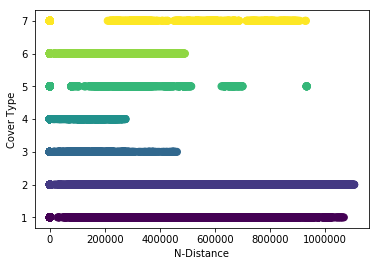

In [53]:
plt.scatter(X.N_Distance, Y, s=50, c=data.Cover_Type)
plt.xlabel("N-Distance")
plt.ylabel("Cover Type")

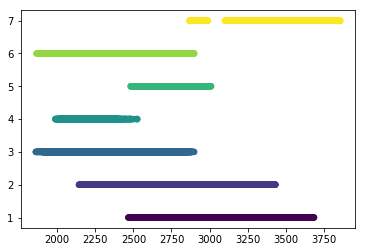

In [54]:
plt.scatter( X.Elevation,Y, s=30, c=data.Cover_Type)


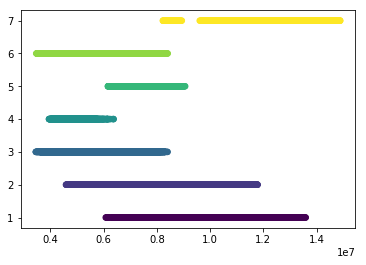

In [55]:
plt.scatter( X.Elevation**2,Y, s=30, c=data.Cover_Type)


In [56]:
X['Elevation-Squared']=X.Elevation**2

In [57]:
np.sum(X.Elevation<=0)

0

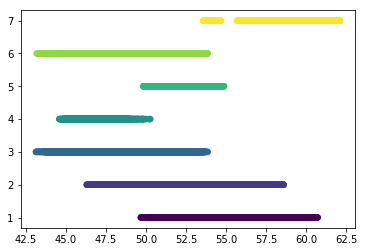

In [58]:
plt.scatter( np.sqrt(X.Elevation),Y, s=30, c=data.Cover_Type)


In [59]:
X['Elevation-Sqrt']=np.sqrt(X.Elevation)

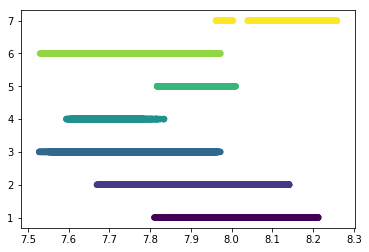

In [60]:
plt.scatter( np.log(X.Elevation),Y, s=30, c=data.Cover_Type)

In [61]:
X['Elevation-Log']=np.log(X.Elevation)

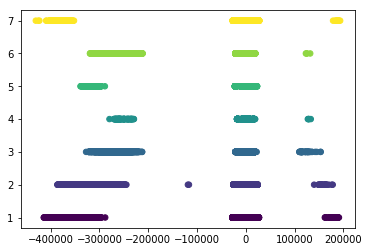

In [62]:
plt.scatter( X.Elevation/(np.sin(X.Slope+1)),data.Cover_Type, s=30, c=data.Cover_Type)

In [63]:
X['Elevation-Slope']=X.Elevation/np.sin(X.Slope+0.1)

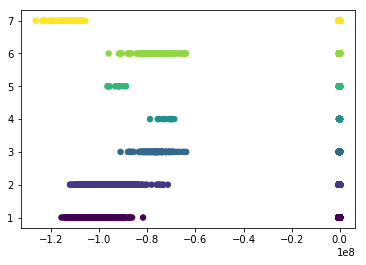

In [64]:
plt.scatter( X.Elevation/np.sin(X.Aspect+1),data.Cover_Type, s=30, c=data.Cover_Type)

In [65]:
X['Elevation-Aspect']=X.Elevation/np.sin(X.Aspect+1)

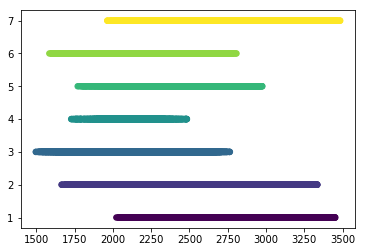

In [66]:
plt.scatter( X.Elevation -X.Distance_To_Hydrology,Y, s=30, c=data.Cover_Type)

In [67]:
X['Elevation-Hydro']=X.Elevation -X.Distance_To_Hydrology

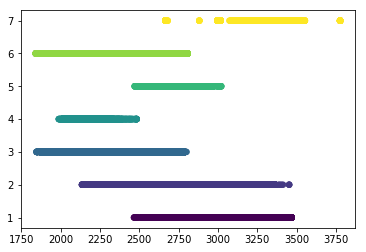

In [68]:
plt.scatter( X.Elevation -X.Vertical_Distance_To_Hydrology,Y, s=30, c=data.Cover_Type)


In [69]:
X['Elevation_V_Hydro']=X.Elevation -X.Vertical_Distance_To_Hydrology

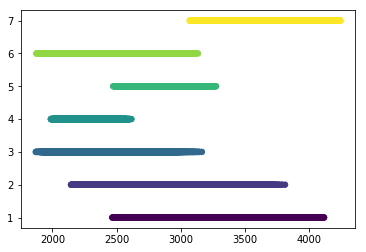

In [70]:
plt.scatter( X.Elevation +X.Vertical_Distance_To_Hydrology,Y, s=30, c=data.Cover_Type)


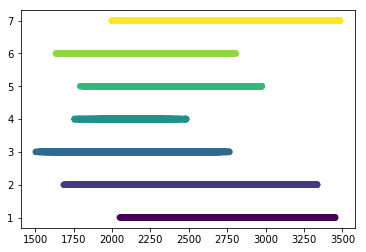

In [71]:
plt.scatter( X.Elevation -X.Horizontal_Distance_To_Hydrology,Y, s=30, c=data.Cover_Type)


In [72]:
X['Elevation_H_Hydro']=X.Elevation -X.Horizontal_Distance_To_Hydrology

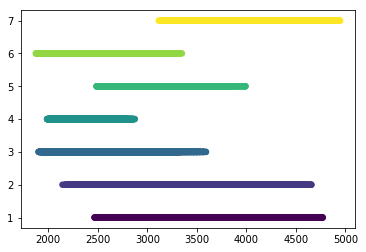

In [73]:
plt.scatter( X.Elevation +X.Horizontal_Distance_To_Hydrology,Y, s=30, c=data.Cover_Type)

In [74]:
X['Elevation_sum_H_Hydro']=X.Elevation +X.Horizontal_Distance_To_Hydrology

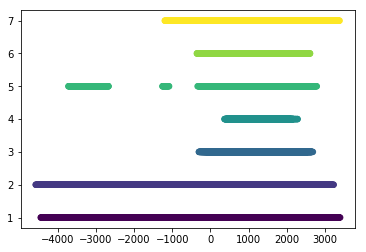

In [75]:
plt.scatter( X.Elevation -X.Horizontal_Distance_To_Fire_Points,Y, s=30, c=data.Cover_Type)

In [76]:
X['Elevation_Fire']=X.Elevation -X.Horizontal_Distance_To_Fire_Points

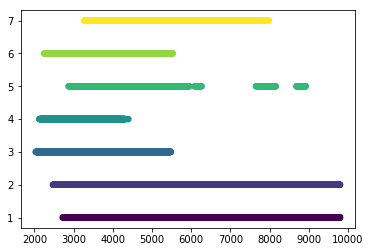

In [77]:
plt.scatter( X.Elevation + X.Horizontal_Distance_To_Fire_Points,Y, s=30, c=data.Cover_Type)


In [78]:
X['Elevation_sum_Fire']=X.Elevation + X.Horizontal_Distance_To_Fire_Points

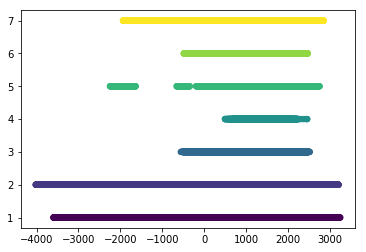

In [79]:
plt.scatter( X.Elevation -X.Horizontal_Distance_To_Roadways,Y, s=30, c=data.Cover_Type)

In [80]:
X['Elevation_Road']=X.Elevation -X.Horizontal_Distance_To_Roadways

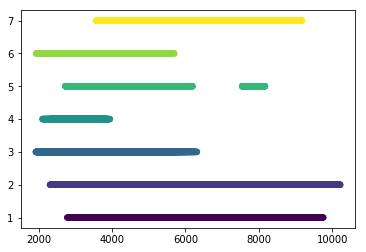

In [81]:
plt.scatter( X.Elevation + X.Horizontal_Distance_To_Roadways,Y, s=30, c=data.Cover_Type)

In [82]:
X['Elevation_sum_Road']=X.Elevation + X.Horizontal_Distance_To_Roadways

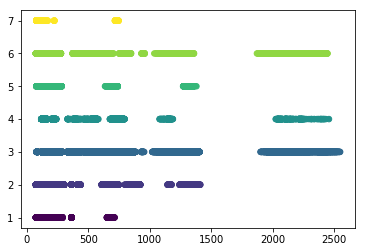

In [83]:
plt.scatter( X.Elevation/(X.Soil_Class+1),data.Cover_Type, s=30, c=data.Cover_Type)

In [84]:
X['Elevation_by_Soil']= X.Elevation/(X.Soil_Class+1)

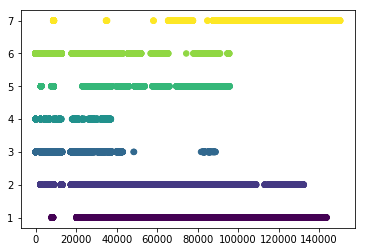

In [85]:
plt.scatter( X.Elevation*X.Soil_Class,data.Cover_Type, s=30, c=data.Cover_Type)

In [86]:
X['Elevation_x_Soil']= X.Elevation*X.Soil_Class

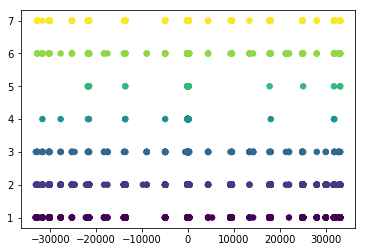

In [87]:
plt.scatter( np.sin(X.Slope)/(np.sin(X.Aspect+1)),data.Cover_Type, s=30, c=data.Cover_Type)

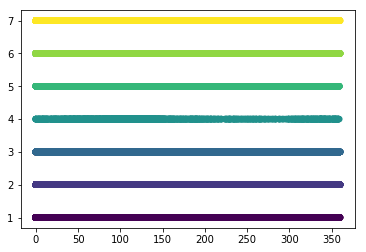

In [88]:
plt.scatter( X.Aspect,data.Cover_Type, s=30, c=data.Cover_Type)

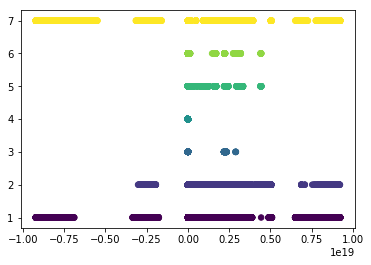

In [89]:
plt.scatter( X.Elevation*(X.Soil_Class)**10,data.Cover_Type, s=30, c=data.Cover_Type)

In [90]:
X['ElevationSoil10']= X.Elevation*(X.Soil_Class)**10 /np.max(X.Elevation*(X.Soil_Class)**10)

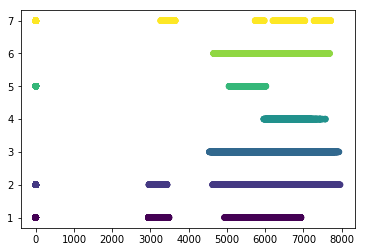

In [91]:
plt.scatter( X.Elevation*(X.Wilderness_Area),data.Cover_Type, s=30, c=data.Cover_Type)

In [92]:
X['ElevationWilderness']=X.Elevation*X.Wilderness_Area

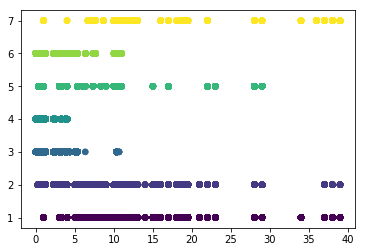

In [93]:
plt.scatter( X.Soil_Class/(X.Wilderness_Area+1),data.Cover_Type, s=30, c=data.Cover_Type)

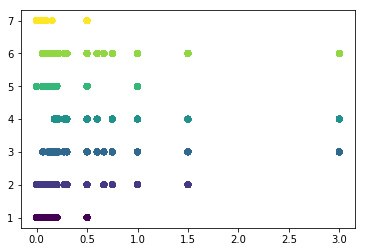

In [94]:
plt.scatter( (X.Wilderness_Area)/(X.Soil_Class+1),data.Cover_Type, s=30, c=data.Cover_Type)


In [95]:
X['Wildernesss_by_Soil']=X.Wilderness_Area/(X.Soil_Class+1)

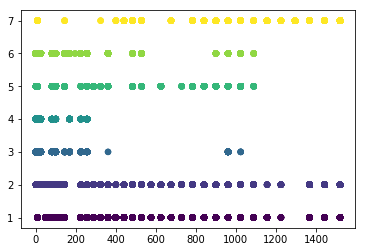

In [96]:
plt.scatter( X.Soil_Class**2,data.Cover_Type, s=30, c=data.Cover_Type)

In [97]:
X['Soil_Class2'] = X.Soil_Class**2

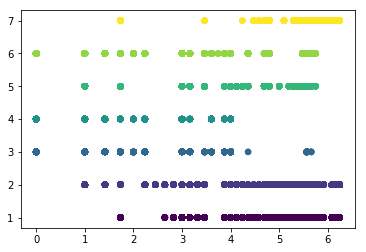

In [98]:
plt.scatter( np.sqrt(X.Soil_Class),data.Cover_Type, s=30, c=data.Cover_Type)

In [99]:
X['Soil_sqrt'] = np.sqrt(X.Soil_Class)

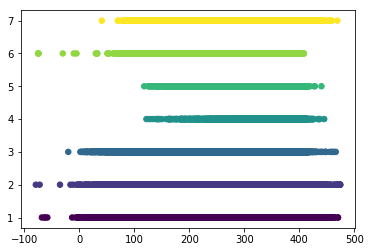

In [100]:
plt.scatter( -X.Hillshade_3pm+X.Hillshade_9am+X.Hillshade_Noon,data.Cover_Type, s=30, c=data.Cover_Type)

In [101]:
X['Shade912_3'] = -X.Hillshade_3pm+X.Hillshade_9am+X.Hillshade_Noon

In [102]:
X['Shade93_12'] = X.Hillshade_3pm+X.Hillshade_9am-X.Hillshade_Noon

In [103]:
X['Shade123_9'] = X.Hillshade_3pm-X.Hillshade_9am+X.Hillshade_Noon

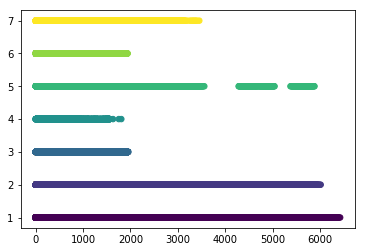

In [104]:
plt.scatter(np.abs(X.Horizontal_Distance_To_Fire_Points-X.Horizontal_Distance_To_Roadways ),data.Cover_Type, s=30, c=data.Cover_Type)

In [105]:
X['Abs_Fire_Roads'] =np.abs(X.Horizontal_Distance_To_Fire_Points-X.Horizontal_Distance_To_Roadways )

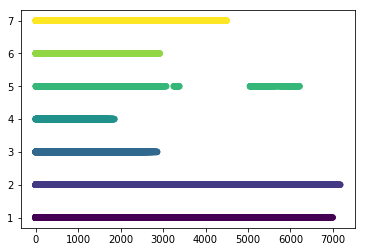

In [106]:
plt.scatter(np.abs(X.Horizontal_Distance_To_Fire_Points-X.Horizontal_Distance_To_Hydrology ),data.Cover_Type, s=30, c=data.Cover_Type)

In [107]:
X['Abs_Fire_Hydro'] =np.abs(X.Horizontal_Distance_To_Fire_Points-X.Horizontal_Distance_To_Hydrology )

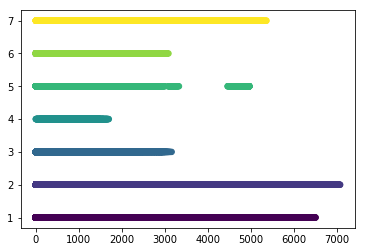

In [108]:
plt.scatter(np.abs(X.Horizontal_Distance_To_Roadways-X.Horizontal_Distance_To_Hydrology ),data.Cover_Type, s=30, c=data.Cover_Type)

In [109]:
X['Abs_Roads_Hydro'] =np.abs(X.Horizontal_Distance_To_Roadways-X.Horizontal_Distance_To_Hydrology )

We add a bit of clustering with gaussian mixture.

In [110]:
gm = GaussianMixture(n_components=10)
gm.fit(X)

X['Gaussian_Mixture'] = gm.predict(X)

In [111]:
X.shape

(581012, 42)

# Models 

In [112]:
X_train_valid, X_test, Y_train_valid, Y_test = train_test_split(X, 
                                                      Y, 
                                                      test_size = 0.20,
                                                      random_state=42)


In [113]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train_valid, 
                                                      Y_train_valid, 
                                                      test_size = 0.20,
                                                      random_state=42)

## Random Forests

In [114]:
rf = RandomForestClassifier(n_estimators=600, 
                            criterion='gini',
                            max_depth=133,
                            max_features='auto',
                            random_state=42)

In [115]:
rf.fit(X_train, Y_train) 
Y_pred = rf.predict(X_valid)
print("Accuracy:",metrics.accuracy_score(Y_valid, Y_pred))

Accuracy: 0.9721821819668252


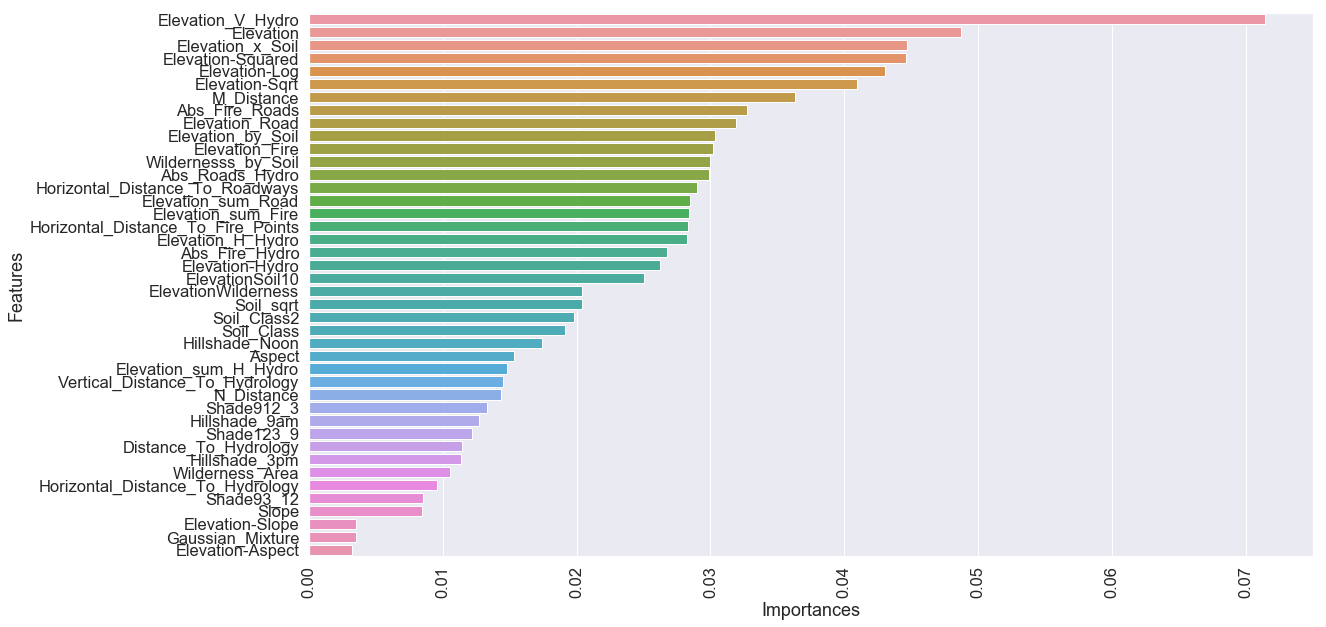

In [116]:
sns.set(font_scale=1.5)

importances = pd.DataFrame({'Features': X_train.columns, 
                             'Importances': rf.feature_importances_})
    
importances.sort_values(by=['Importances'], axis='index', ascending=False, inplace=True)

fig = plt.figurbe(figsize=(18,10))
sns.barplot(x='Importances', y='Features', data=importances)
plt.xticks(rotation='vertical')
plt.show()

In [148]:
Y_pred_test = rf.predict(X_test)
print("Test accuracy:",metrics.accuracy_score(Y_test, Y_pred_test))

Test accuracy: 0.971850984914331


## XGBoost

In [117]:
xgb = XGBClassifier(learning_rate=0.1, n_estimators=450, max_depth=25,
                        min_child_weight=3, gamma=0.05, subsample=0.6, colsample_bytree=1.0,
                        objective='multiclass:softmax', nthread=4, scale_pos_weight=1, seed=42)

In [118]:
xgb_model=xgb.fit(X_train,Y_train)

In [119]:
Y_pred = xgb_model.predict(X_valid)

print("Accuracy:",metrics.accuracy_score(Y_valid, Y_pred))

Accuracy: 0.9749575095200189


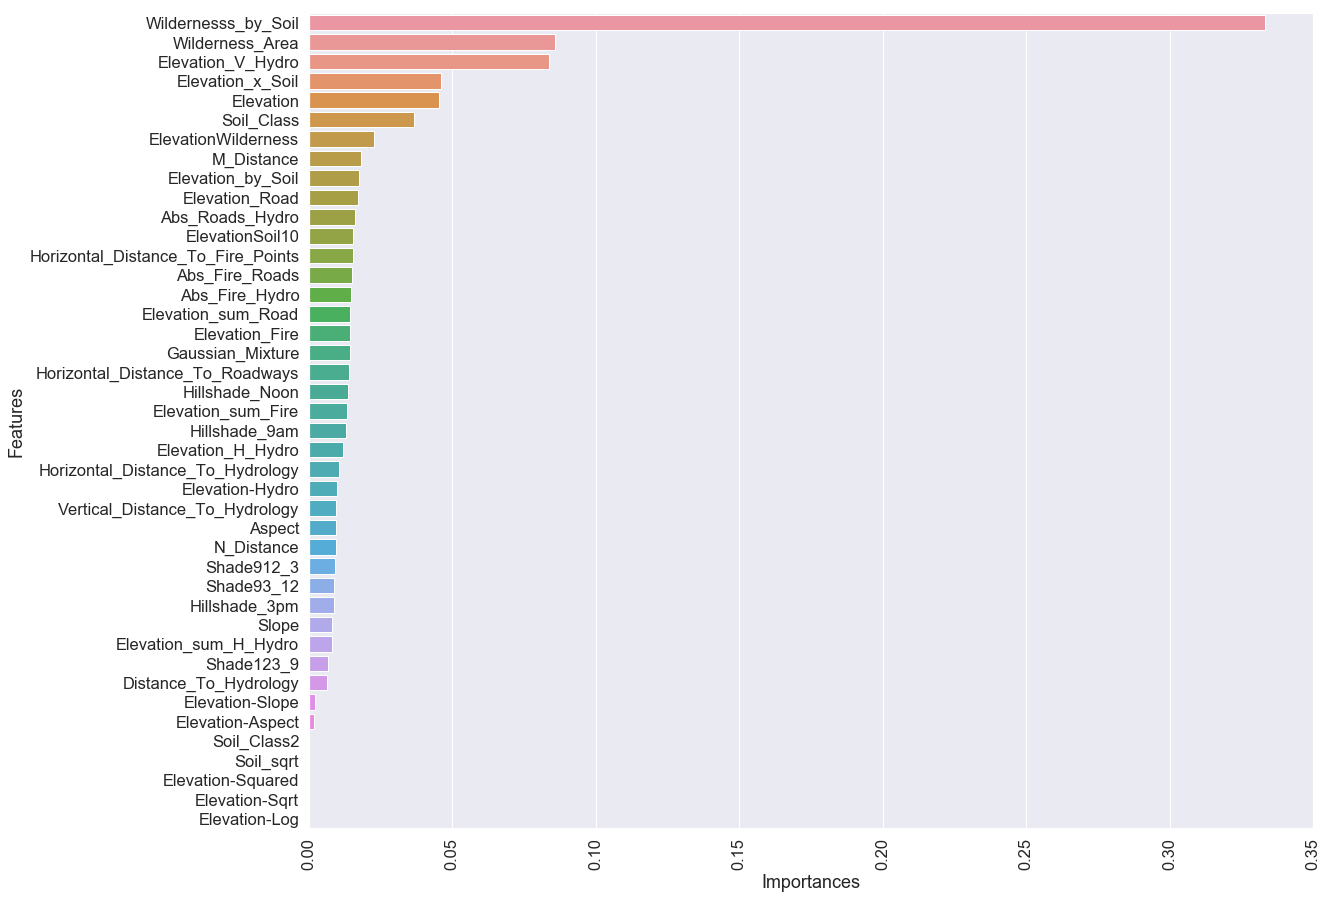

In [120]:
sns.set(font_scale=1.5)

importances = pd.DataFrame({'Features': X_train.columns, 
                             'Importances': xgb_model.feature_importances_})
    
importances.sort_values(by=['Importances'], axis='index', ascending=False, inplace=True)

fig = plt.figure(figsize=(18,15))
sns.barplot(x='Importances', y='Features', data=importances)
plt.xticks(rotation='vertical')
plt.show()

In [149]:
Y_pred_test = xgb_model.predict(X_test)

print("Test accuracy:",metrics.accuracy_score(Y_test, Y_pred_test))

Test accuracy: 0.9745101245234632


## Extra Trees

In [121]:
xtc=ExtraTreesClassifier(
           max_depth=350, 
           n_estimators=450, n_jobs=-1,
           oob_score=False, random_state=42, 
           warm_start=True)

In [122]:
xtc.fit(X_train, Y_train) 

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=350, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=450, n_jobs=-1,
           oob_score=False, random_state=42, verbose=0, warm_start=True)

In [123]:
Y_pred = xtc.predict(X_valid)

print("Accuracy:",metrics.accuracy_score(Y_valid, Y_pred))

Accuracy: 0.9742367849228717


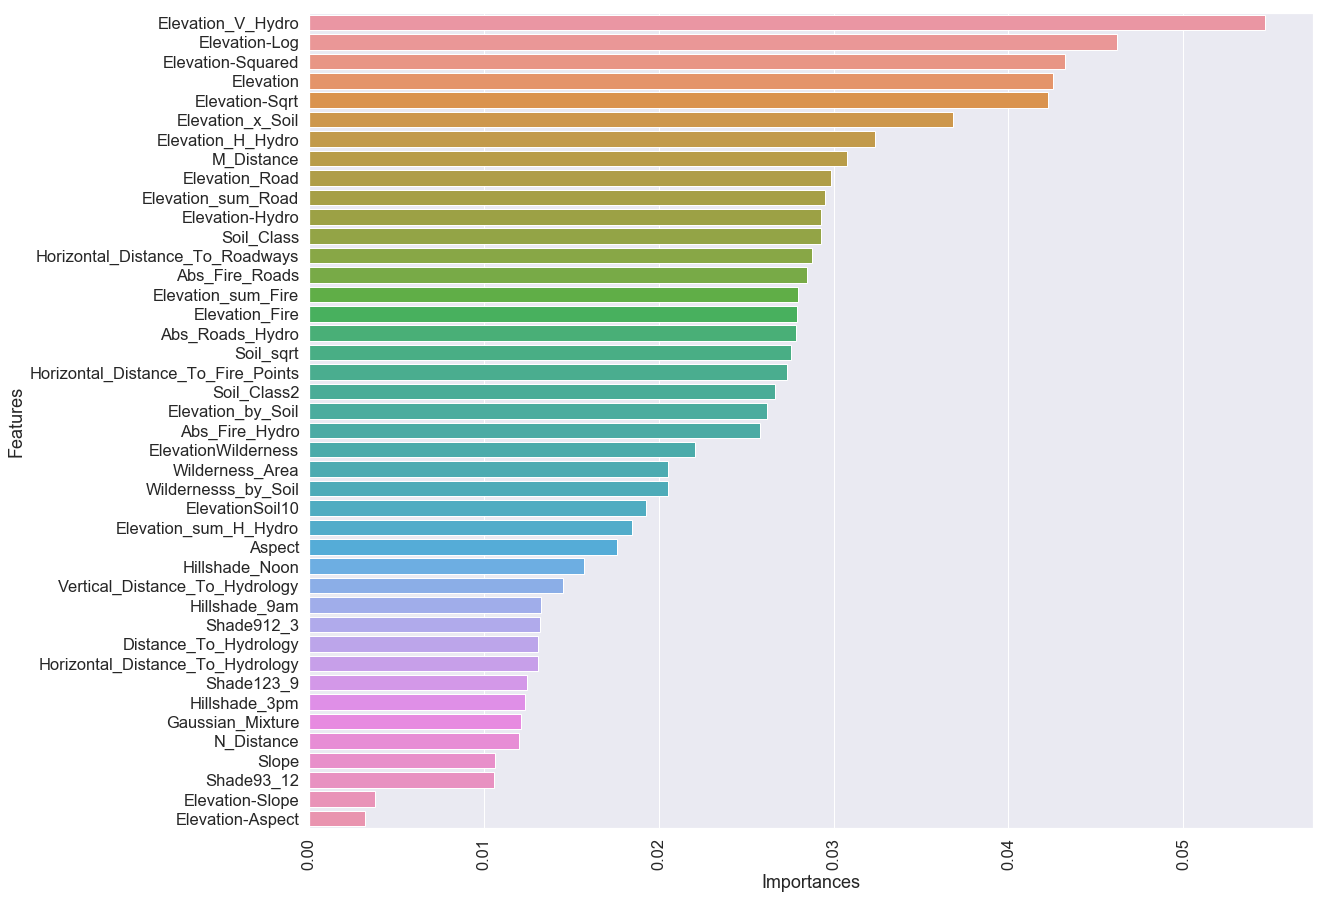

In [124]:
sns.set(font_scale=1.5)

importances = pd.DataFrame({'Features': X_train.columns, 
                             'Importances': xtc.feature_importances_})
    
importances.sort_values(by=['Importances'], axis='index', ascending=False, inplace=True)

fig = plt.figure(figsize=(18,15))
sns.barplot(x='Importances', y='Features', data=importances)
plt.xticks(rotation='vertical')
plt.show()

In [150]:
Y_pred_test = xtc.predict(X_test)

print("Test accuracy:",metrics.accuracy_score(Y_test, Y_pred_test))

Test accuracy: 0.9736925896921766


## Adaboost

In [125]:
ada=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth  = 20,
                                                                        min_samples_split = 2,
                                                                        min_samples_leaf = 1,
                                                                        random_state=42),
                                                                        n_estimators=100,
                                                                        random_state=42)

In [126]:
ada.fit(X_train, Y_train) 

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=20,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
          learning_rate=1.0, n_estimators=100, random_state=42)

In [127]:
Y_pred = ada.predict(X_valid)

print("Accuracy:",metrics.accuracy_score(Y_valid, Y_pred))

Accuracy: 0.9538951399496568


C:\Users\atsub\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\tree\tree.py:512: RuntimeWarning: invalid value encountered in true_divide
  return self.tree_.compute_feature_importances()


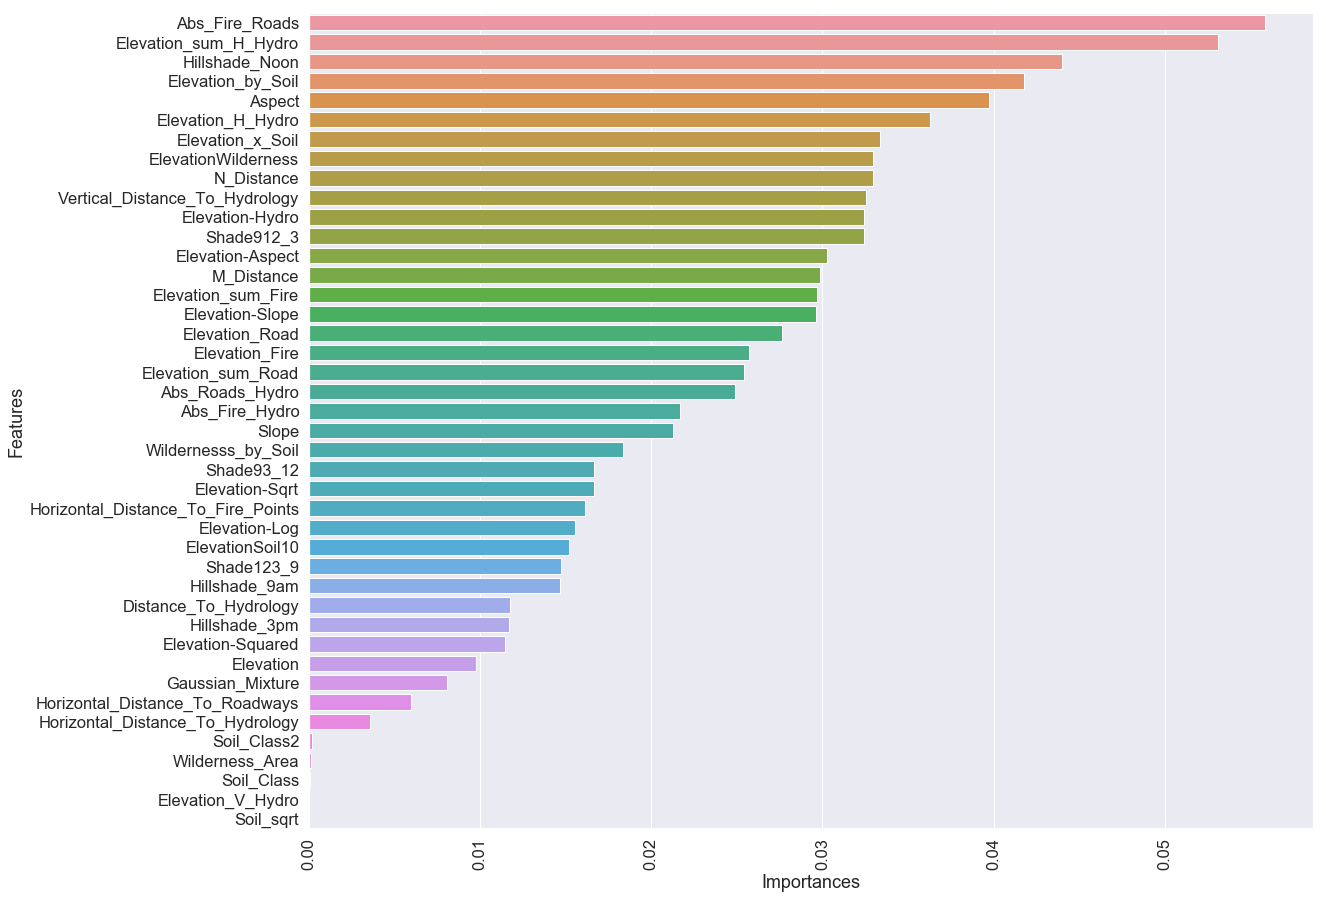

In [128]:
sns.set(font_scale=1.5)

importances = pd.DataFrame({'Features': X_train.columns, 
                             'Importances': ada.feature_importances_})
    
importances.sort_values(by=['Importances'], axis='index', ascending=False, inplace=True)

fig = plt.figure(figsize=(18,15))
sns.barplot(x='Importances', y='Features', data=importances)
plt.xticks(rotation='vertical')
plt.show()

In [151]:
Y_pred_test = ada.predict(X_test)

print("Test accuracy:",metrics.accuracy_score(Y_test, Y_pred_test))

Test accuracy: 0.95427828885657


## LightGBM

In [129]:
lgb_model=lgb.LGBMClassifier(n_estimators=375,
                        num_leaves=100,
                        verbosity=0,
                        random_state=42,
                        n_jobs=-1)

In [130]:
lgb_model.fit(X_train, Y_train) 

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=375, n_jobs=-1, num_leaves=100, objective=None,
        random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0,
        verbosity=0)

In [131]:
Y_pred = lgb_model.predict(X_valid)

print("Accuracy:",metrics.accuracy_score(Y_valid, Y_pred))

Accuracy: 0.9618553817688948


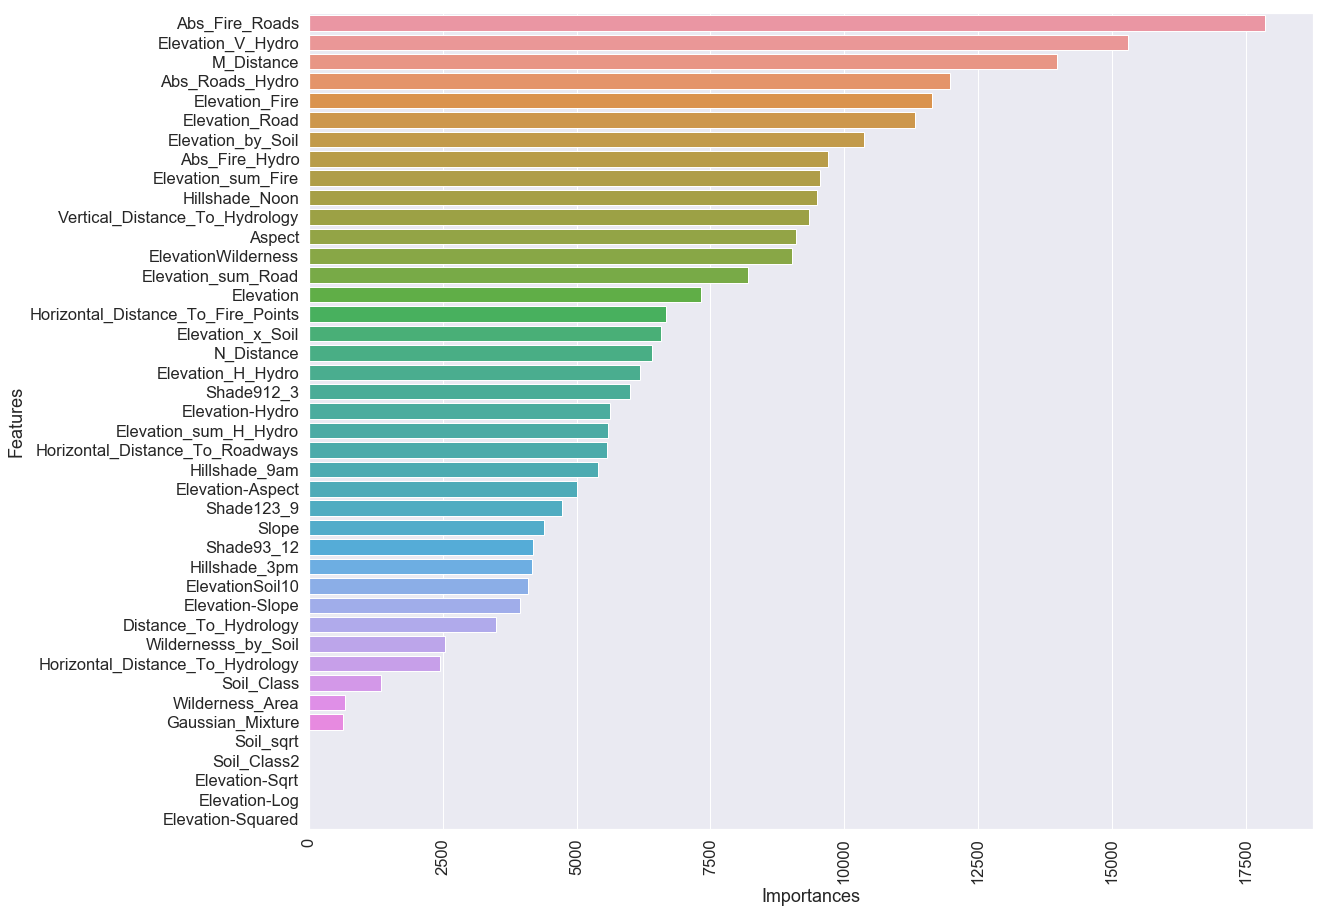

In [132]:
sns.set(font_scale=1.5)

importances = pd.DataFrame({'Features': X_train.columns, 
                             'Importances': lgb_model.feature_importances_})
    
importances.sort_values(by=['Importances'], axis='index', ascending=False, inplace=True)

fig = plt.figure(figsize=(18,15))
sns.barplot(x='Importances', y='Features', data=importances)
plt.xticks(rotation='vertical')
plt.show()

In [152]:
Y_pred_test = lgb_model.predict(X_test)

print("Test accuracy:",metrics.accuracy_score(Y_test, Y_pred_test))

Test accuracy: 0.9613779334440591


## Catboost

In [177]:
cat= CatBoostClassifier(n_estimators =6000, 
                        #loss_function='Logloss',
                        eval_metric='Accuracy',
                        metric_period=1000,
                        max_depth = None, 
                        random_state=42)

In [178]:
cat.fit(X_train, Y_train) 

0:	learn: 0.6866130	total: 486ms	remaining: 48m 34s
1000:	learn: 0.8460334	total: 4m 30s	remaining: 22m 31s
2000:	learn: 0.8842131	total: 8m 39s	remaining: 17m 18s
3000:	learn: 0.9060608	total: 12m 49s	remaining: 12m 48s
4000:	learn: 0.9206932	total: 16m 58s	remaining: 8m 28s
5000:	learn: 0.9308076	total: 21m 9s	remaining: 4m 13s
5999:	learn: 0.9385070	total: 25m 23s	remaining: 0us


In [179]:
Y_pred = cat.predict(X_valid)

print("Accuracy:",metrics.accuracy_score(Y_valid, Y_pred))

Accuracy: 0.9273466577741443


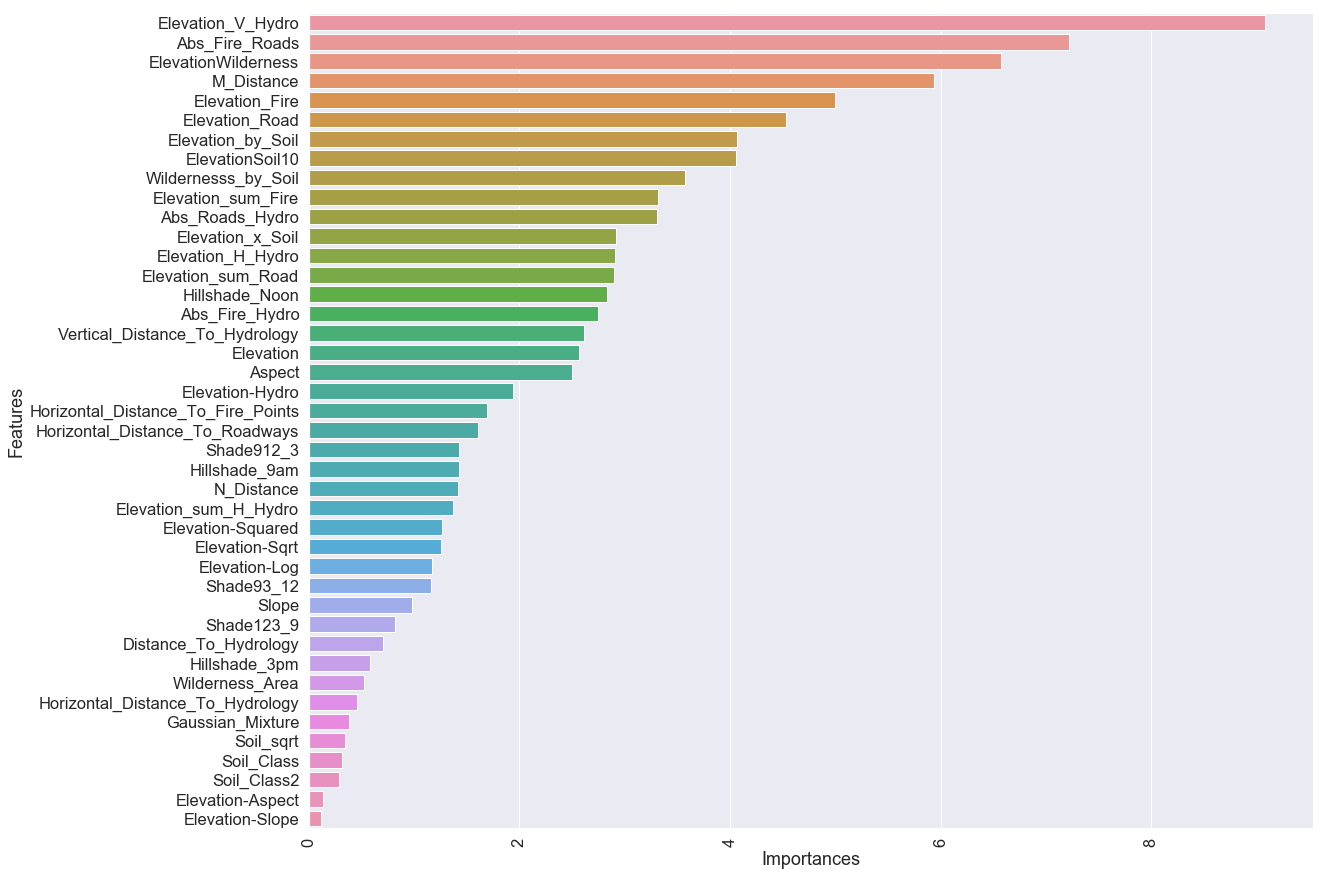

In [180]:
sns.set(font_scale=1.5)

importances = pd.DataFrame({'Features': X_train.columns, 
                             'Importances': cat.feature_importances_})
    
importances.sort_values(by=['Importances'], axis='index', ascending=False, inplace=True)

fig = plt.figure(figsize=(18,15))
sns.barplot(x='Importances', y='Features', data=importances)
plt.xticks(rotation='vertical')
plt.show()

In [181]:
Y_pred_test = cat.predict(X_test)

print("Test accuracy:",metrics.accuracy_score(Y_test, Y_pred_test))

Test accuracy: 0.9272738225347023
